The goal of this project is to predict the price of the mentor per month based on the following variables:
   - num_reviews
   - rating
   - number of services offered

The hypothesis is that the greater the number of reviews, the higher the rating, and the greater the number of services offered, the higher the price the mentor is able to charge. The higher the rating is likely to have the greatest weight on predicting the price of the mentor.

The project will be structured as followed:
1. Exploratory analysis
2. Regression
   - Missing data.
   - Outliers.
   - Regression.
   - Conclusion.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [2]:
mentors = pd.read_csv(r"C:\Users\jonat\data_projects\mentors_scraping\data\mentors_profiles.csv")

In [3]:
mentors.head(5)

,name,job_title,company,rating,num_reviews,dollars_month,country,short_description,long_description,service_1,service_2,service_3,service_4
0,Marco Suma,Senior Software Engineer (Tech Lead),Ex-Meta,0.0,0.0,90,Singapore,11+ years of experience in software engineerin...,👋 Hi everyone! I am a Senior Software Engineer...,NaN,NaN,NaN,NaN
1,James Vosper Robinson,COO,NaN,0.0,0.0,300,Germany,NaN,Experienced Operations Leader with a track rec...,NaN,NaN,NaN,NaN
2,Sam Rowlands,Startup Mentor / Advisor,NaN,0.0,0.0,300,United Kingdom,"Serial Founder | Ex-developer, scaled business...","Lifelong Entrepreneur, ex-developer, passionat...",NaN,NaN,NaN,NaN
3,Ali Masri,Data Engineer,Ford,0.0,0.0,350,United States of America,NaN,I am a Lead Data Engineer at Ford Motor Compan...,Chat,4 Calls,Tasks,Hands-on
4,Bernd Fondermann,Product Manager and Tech Consultant,brainlounge,0.0,0.0,240,Germany,NaN,"Being a consultant for 20+ years, all my energ...",NaN,NaN,NaN,NaN


### Exploratory analysis.

In [4]:
mentors.describe()

,rating,num_reviews,dollars_month
count,1139.000000,1139.000000,1139.000000
mean,1.984811,2.742757,195.219491
std,2.426155,7.163520,95.364692
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,120.000000
50%,0.000000,0.000000,180.000000
75%,5.000000,2.000000,240.000000
max,5.000000,77.000000,1010.000000


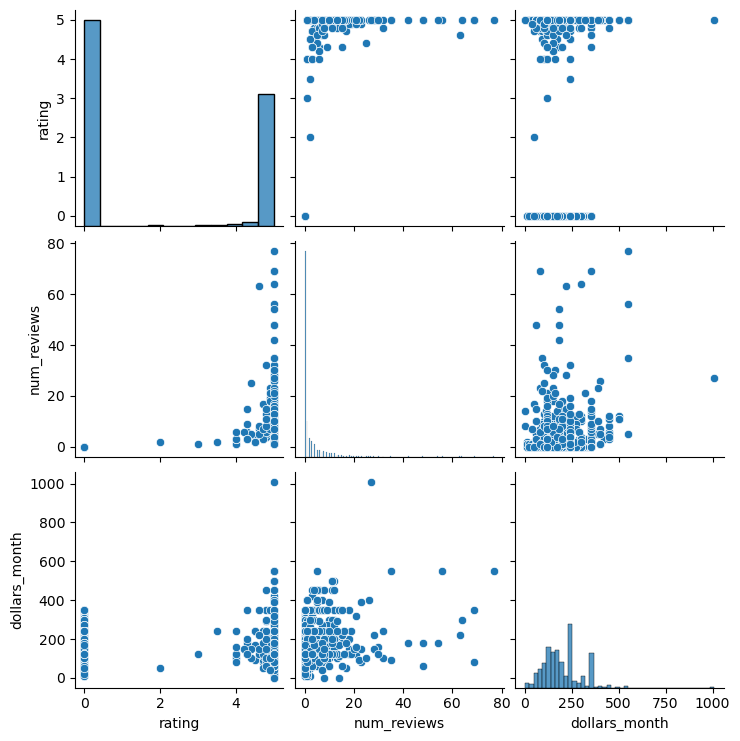

In [5]:
# Pairplot to visualize the relationships between numeric variables
sns.pairplot(mentors[['rating', 'num_reviews', 'dollars_month']])

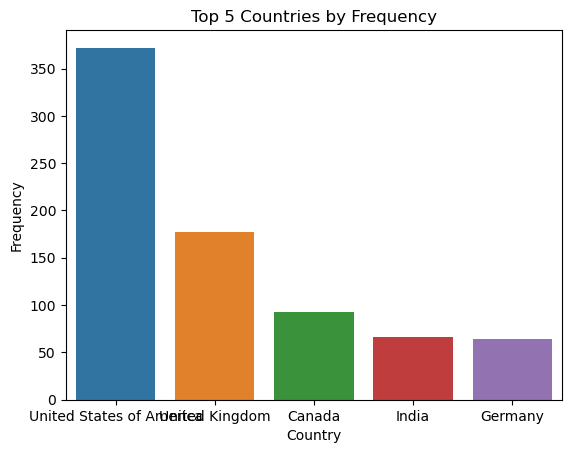

In [70]:
# Count the frequency of each country
country_count = mentors['country'].value_counts()

# Get the top 5 countries by frequency
top5_countries = country_count.nlargest(5)

# Create the barplot
sns.barplot(x=top5_countries.index, y=top5_countries.values)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 5 Countries by Frequency')

# Show the plot
plt.show()

The top 5 countries ranked are:
1. USA
2. UK
3. Canada
4. India
5. Germany

People either rate mentors highly, or don't rate them at all.

There is a positive skew to the dollars_month charged by mentors, with the mean being at 195 USD. 

There is a large positive skew to the num_reviews provided to mentors, with a significant percentage being attributed to no ratings at all.

### Missing data.

Assessing missingness in our dataset is crucial to an effective multivariate regression analysis. 

There are 3 possible states of missingness - MCAR, MAR, NMAR.
MCAR indicates that missingness is independent on both observed and unobserved variables.
MAR indicates that missingness is only dependent on observed variables and independent of unobserved variables.
NMAR indicates that missingness is due to unobserved variables.

Since regression analysis predicts the values of a continuous quantitative variables, we will only be including quantitative variables. This will be: num_reviews, rating, number of services offered.

We will be deciding the most appropriate route for addressing the missig values through the following steps:
1. 
2. 

A quick missing data command tells us that we have multiple fields with a large number of missing values. Let us investigate further.

<AxesSubplot:>

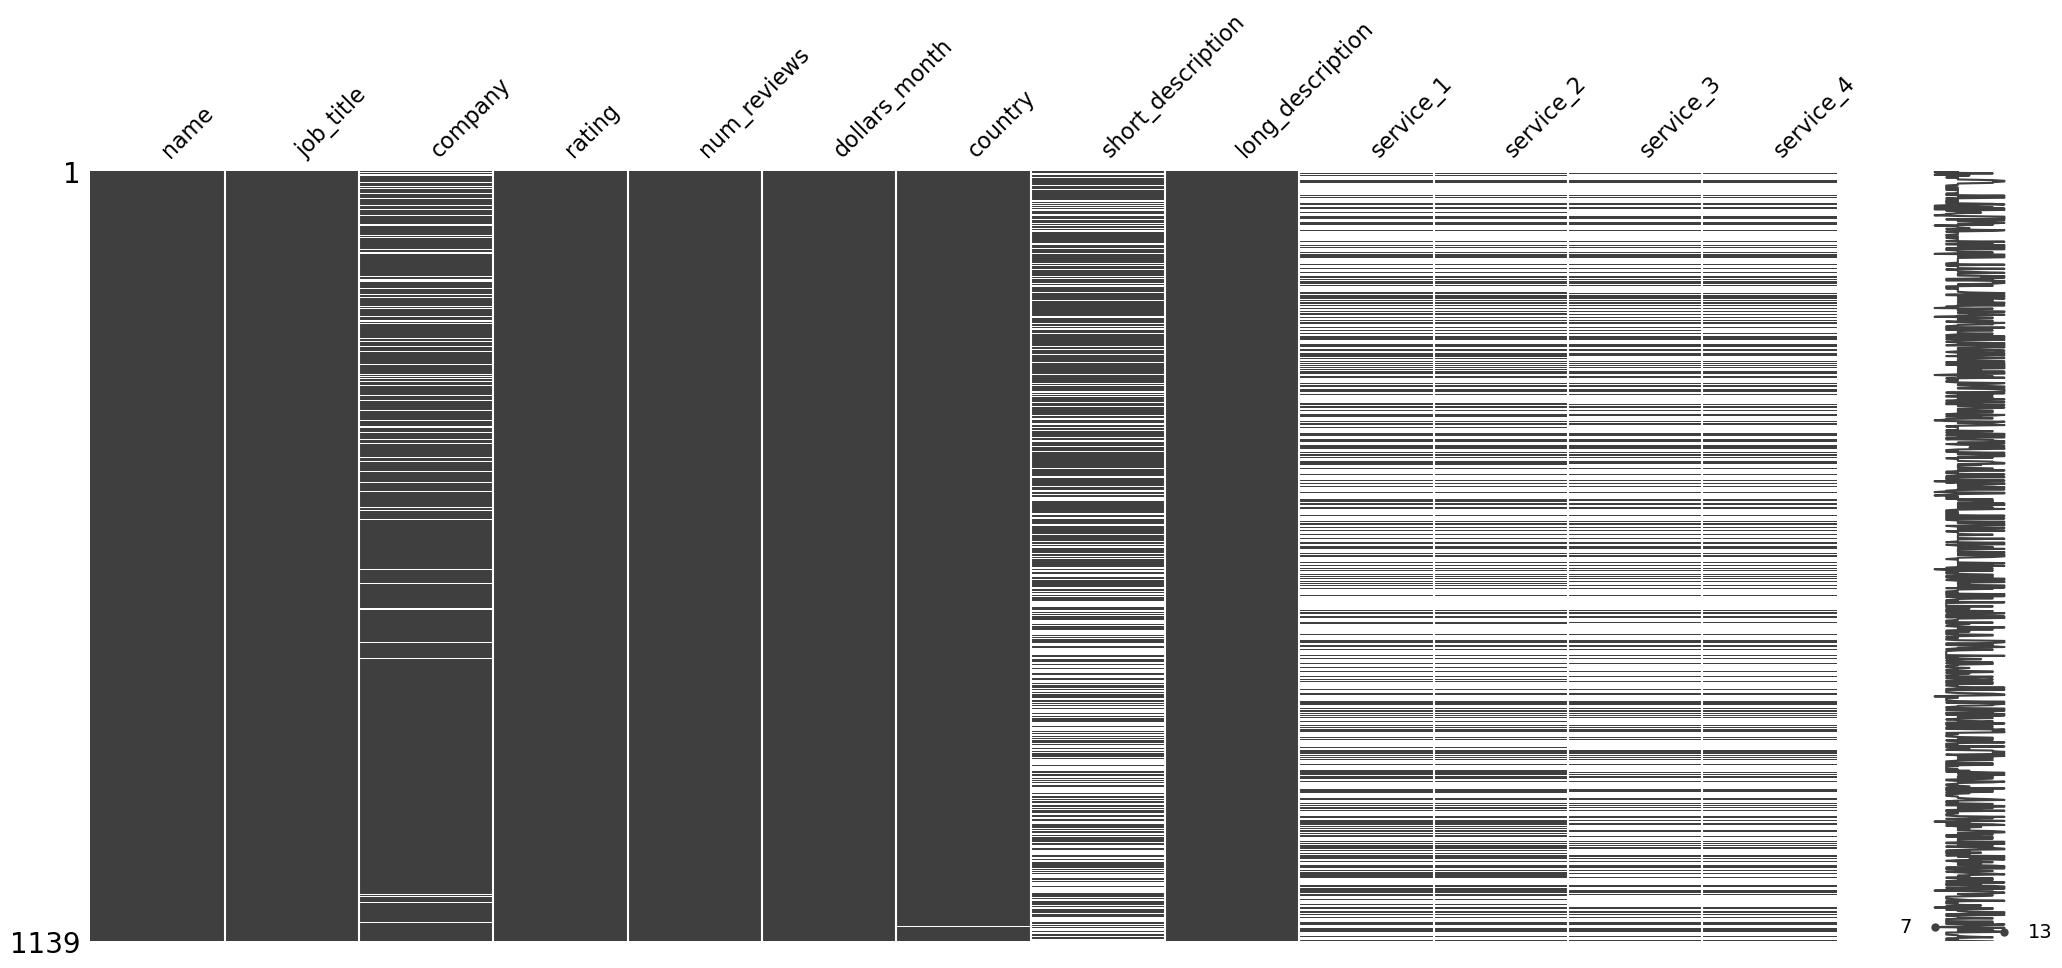

In [14]:
msno.matrix(mentors)

It seems that there are 5 primary fields with missing data - company, short_description, and service_1/2/3/4. Company and short_description is of not much interest to us in the regression analysis so we can ignore it. 

We can then assess for the correlation in missingness between the variables in our dataset. 

<AxesSubplot:>

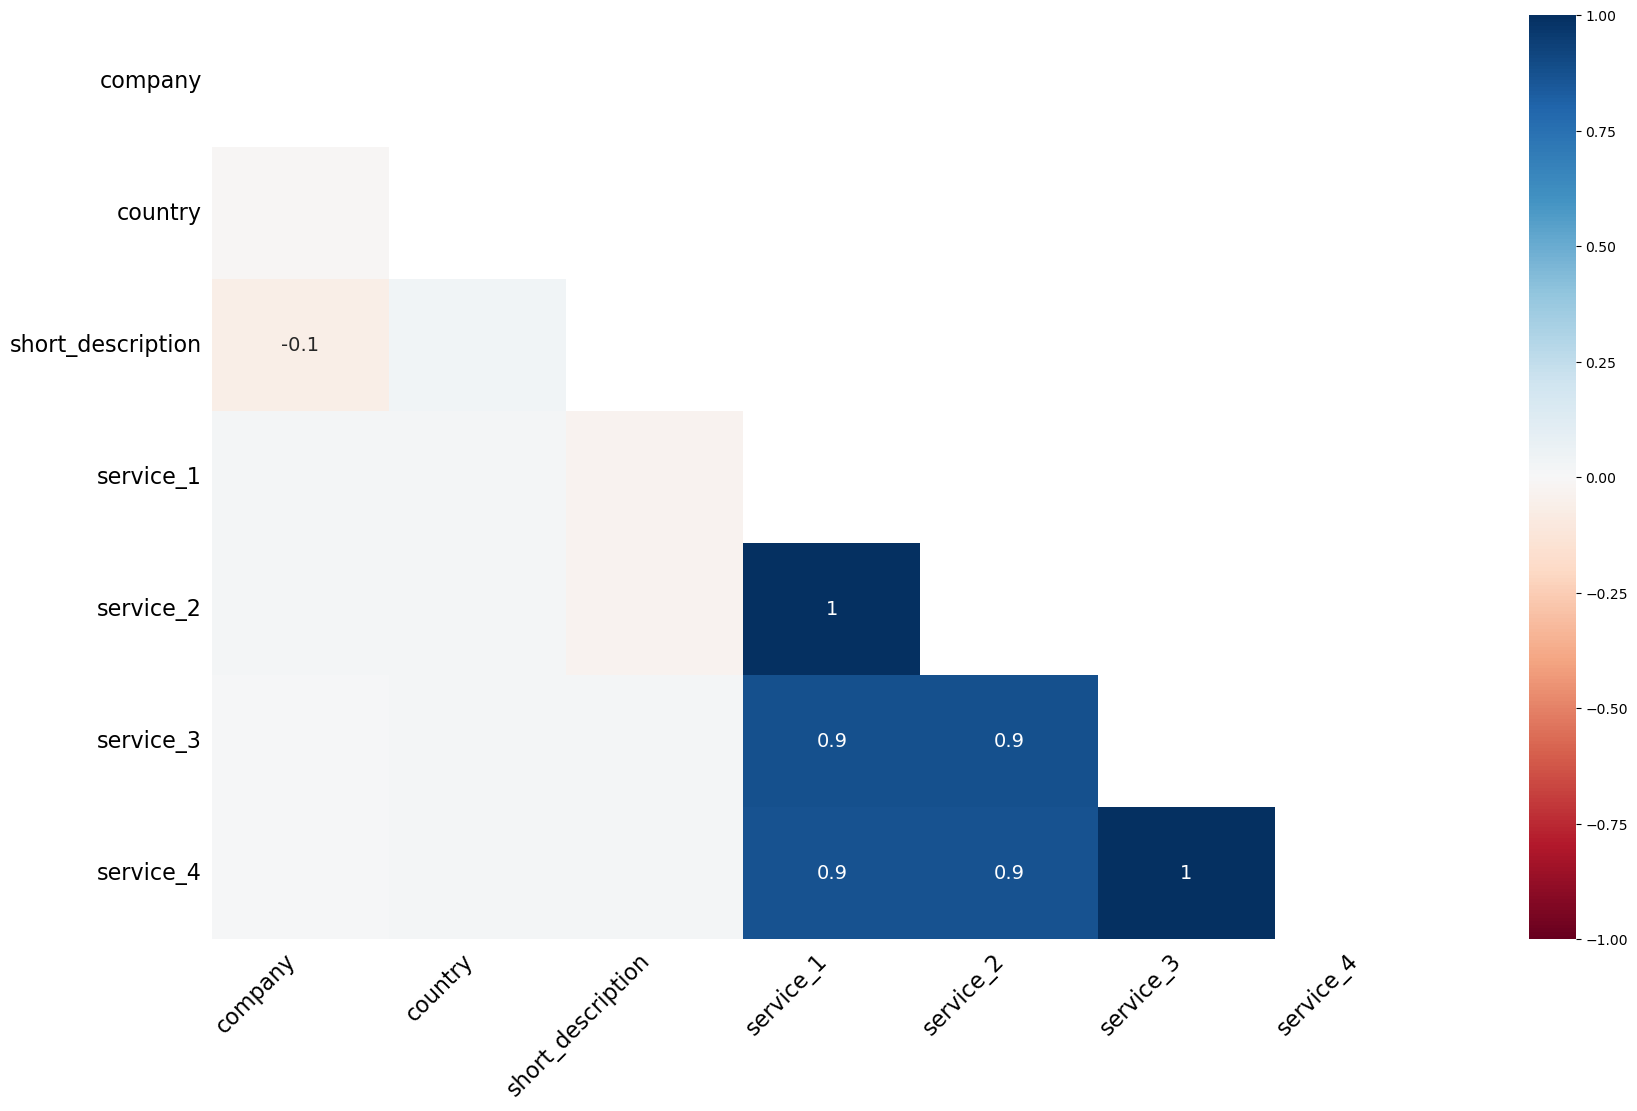

In [15]:
msno.heatmap(mentors)

The above amtrix indicates that all 4 variables have a correlation matrix of close to 1, indicating that the state of one condition reflects a similar state in the other variable - i.e. if one variable is present the other is highly likely to be present, and if one variable is missing, the other variable is very likely to be missing. 

Values within the service columns are highly likely to be MCAR, however there is still a possibility that both observed and unobserved variables within the whole dataset have an impact on their missingness.

For the scope of this project, it is unfortunately not possible to investigate NMAR. 

Instead, we can map the distribution of the other variables of interest - rating, num_reviews, dollars_month - to verify whether there is any relationship between these variables and the missingness of the services variables. 

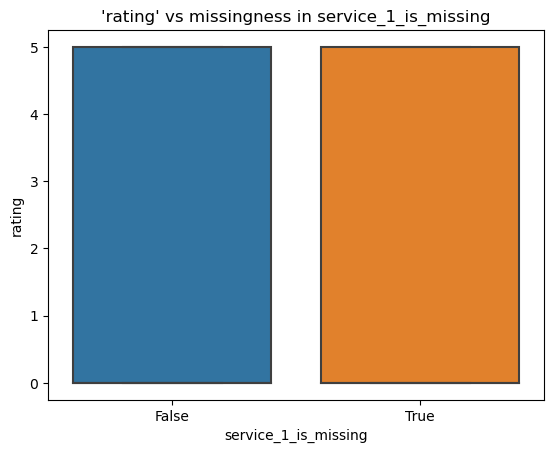

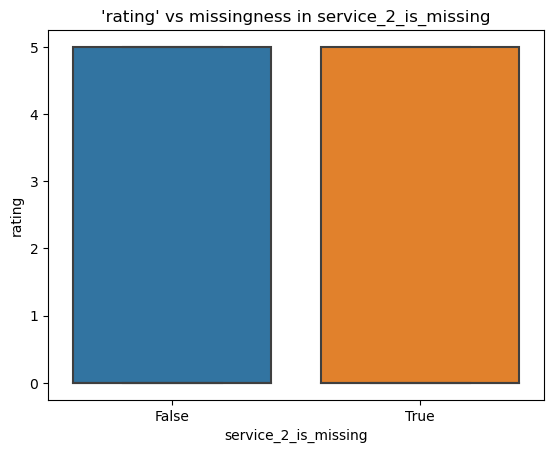

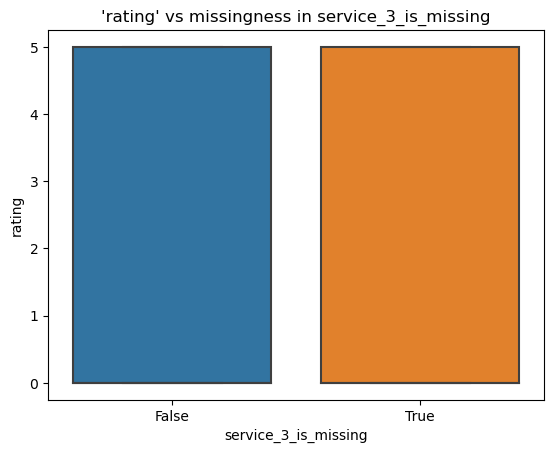

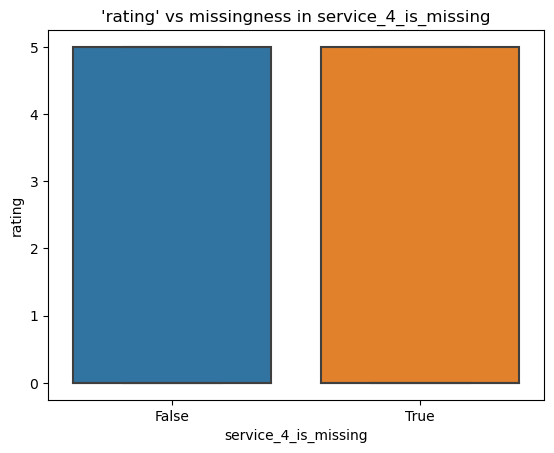

In [29]:
# Create binary columns to indicate if a service is missing
for col in ['service_1', 'service_2', 'service_3', 'service_4']:  # Add other service columns as needed
    mentors[f'{col}_is_missing'] = mentors[col].isna()

# Create individual plots for each 'service_is_missing' column vs 'rating'
for col in ['service_1_is_missing', 'service_2_is_missing', 'service_3_is_missing', 'service_4_is_missing']:  # Add other service columns as needed
    plt.figure()
    sns.boxplot(x=col, y='rating', data=mentors)
    plt.title(f"'rating' vs missingness in {col}")
    plt.show()

As we can see, the distribution of True (missing), False (present), are equal across the ratings. 
This means that there is a low probability that the relationship between 'rating' and 'services' are MAR, and high likelihood o MCAR with respect to rating.

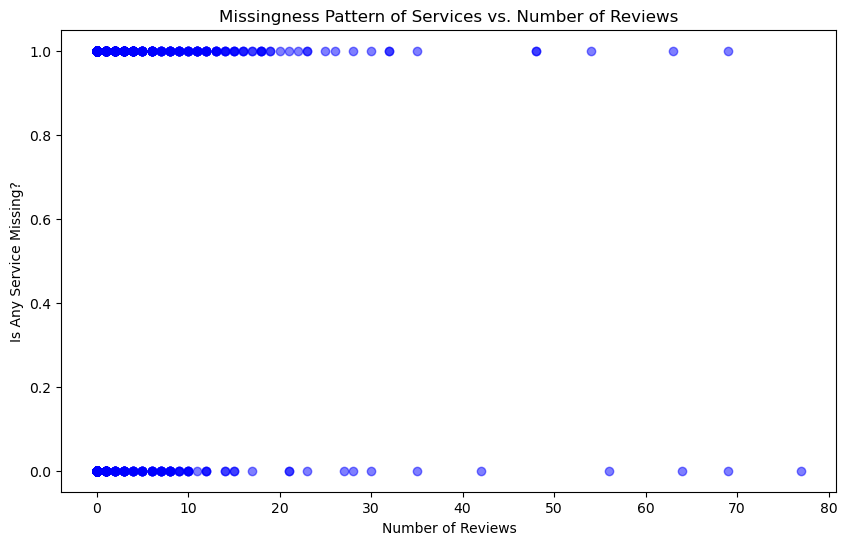

In [23]:
# Create a new column to indicate if any service is missing
mentors['any_service_missing'] = mentors[['service_1', 'service_2', 'service_3', 'service_4']].isna().any(axis=1)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mentors['num_reviews'], mentors['any_service_missing'], c='blue', alpha=0.5)
plt.xlabel('Number of Reviews')
plt.ylabel('Is Any Service Missing?')
plt.title('Missingness Pattern of Services vs. Number of Reviews')
plt.show()

Similarly, the fairly equal distribution of the missingness across the number of reviews indicates a low probability of MAR, and high likelihood of MCAR with respect to number of reviews. 

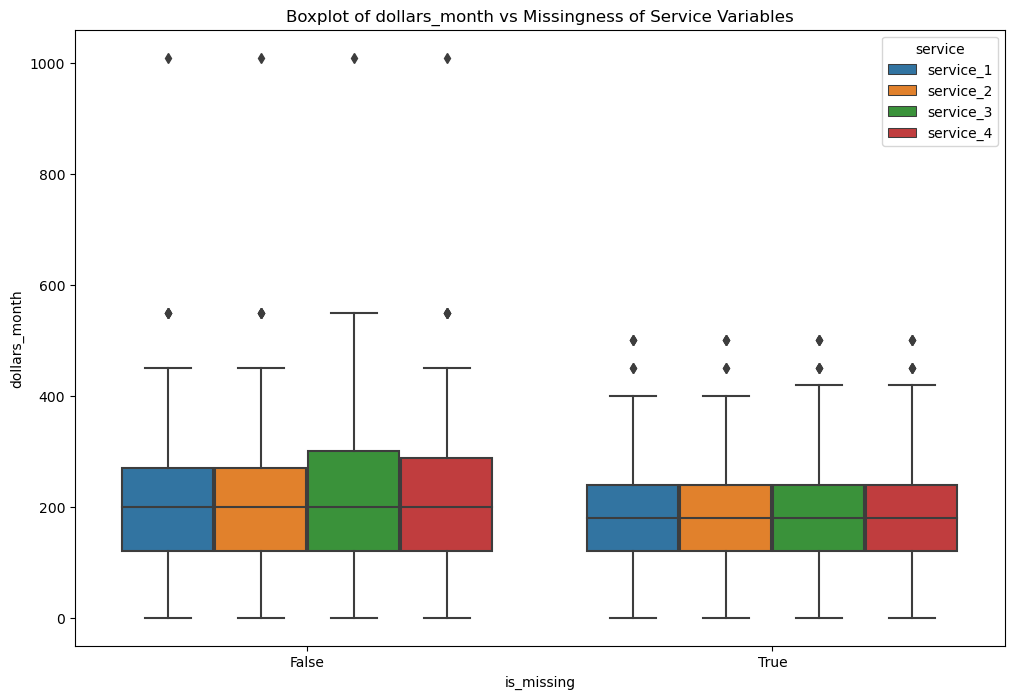

In [25]:
# Create a new dataframe to store missingness indicators
mentors_missing = mentors.copy()
service_columns = ['service_1', 'service_2', 'service_3', 'service_4']

for col in service_columns:
    mentors_missing[col] = mentors[col].isna()

# Melt the dataframe to make it suitable for seaborn's boxplot
mentors_melted = pd.melt(mentors_missing, id_vars=['dollars_month'], value_vars=service_columns,
                    var_name='service', value_name='is_missing')

plt.figure(figsize=(12, 8))
sns.boxplot(x='is_missing', y='dollars_month', hue='service', data=mentors_melted)
plt.title('Boxplot of dollars_month vs Missingness of Service Variables')
plt.show()

Finally, the distribution of missingness aross dollars_month similarly implies a low likelihood of MAR, and high likelihood of MCAR with respect to dollars_month variable.

Since we have now validated that the variables of interest in our dataset - num_reviews, rating, dollars_month - have a high likelihood of being MCAR with respect to the service columns, we may now pursue listwise deletion.

In [30]:
# Calculate the initial sample size
initial_sample_size = len(mentors)

# Perform listwise deletion to remove any rows with NaN values
mentors_listwise_deleted = mentors.dropna(how='any', subset=['rating', 'num_reviews', 'dollars_month', 'service_1', 'service_2', 'service_3', 'service_4'])

# Calculate the sample size after listwise deletion
final_sample_size = len(mentors_listwise_deleted)

# Calculate the total number and percentage decrease in sample size
total_decrease = initial_sample_size - final_sample_size
percentage_decrease = (total_decrease / initial_sample_size) * 100

print(f"Initial Sample Size: {initial_sample_size}")
print(f"Final Sample Size: {final_sample_size}")
print(f"Total Number of Rows Decreased: {total_decrease}")
print(f"Percentage Decrease in Sample Size: {percentage_decrease:.2f}%")

Initial Sample Size: 1139
Final Sample Size: 366
Total Number of Rows Decreased: 773
Percentage Decrease in Sample Size: 67.87%
